# Project Overview

The objective of this project is to classifie traffic signs and then predict for wich class some given photo belongs. 


In order to do that, a convolutional neuron network will be trained with a dataset containing all the images.


All the signs are listed bellow:

- Classes 

    - ( 0, b'Speed limit (20km/h)') ( 1, b'Speed limit (30km/h)')
    - ( 2, b'Speed limit (50km/h)') ( 3, b'Speed limit (60km/h)')
    - ( 4, b'Speed limit (70km/h)') ( 5, b'Speed limit (80km/h)')
    - ( 6, b'End of speed limit (80km/h)') ( 7, b'Speed limit (100km/h)')
    - ( 8, b'Speed limit (120km/h)') ( 9, b'No passing')
    - (10, b'No passing for vehicles over 3.5 metric tons')
    - (11, b'Right-of-way at the next intersection') (12, b'Priority road')
    - (13, b'Yield') (14, b'Stop') (15, b'No vehicles')
    - (16, b'Vehicles over 3.5 metric tons prohibited') (17, b'No entry')
    - (18, b'General caution') (19, b'Dangerous curve to the left')
    - (20, b'Dangerous curve to the right') (21, b'Double curve')
    - (22, b'Bumpy road') (23, b'Slippery road')
    - (24, b'Road narrows on the right') (25, b'Road work')
    - (26, b'Traffic signals') (27, b'Pedestrians') (28, b'Children crossing')
    - (29, b'Bicycles crossing') (30, b'Beware of ice/snow')
    - (31, b'Wild animals crossing')
    - (32, b'End of all speed and passing limits') (33, b'Turn right ahead')
    - (34, b'Turn left ahead') (35, b'Ahead only') (36, b'Go straight or right')
    - (37, b'Go straight or left') (38, b'Keep right') (39, b'Keep left')
    - (40, b'Roundabout mandatory') (41, b'End of no passing')
    - (42, b'End of no passing by vehicles over 3.5 metric tons')

In [53]:
# importing the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from IPython.display import clear_output
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import Adam
import cv2

This is a python dictionary with the classes and their respective number representation.
The dictionary are gonna be used at the end of the notebook, and will be passed along a funciton,
togheter with the predicted classe of the CNN, so the funciton will be able the return the corresponding key in the dictionary and show us the result in a 'more human representation'. 

Note: the dict is not necessary, it's used only to clarrify the CNN predict output.

In [125]:
dict_ans = {'Speed limit (20km/h)': 0, 'Speed limit (30km/h)': 1, 'Speed limit (50km/h)': 2, 
            'Speed limit (60km/h)': 3, 'Speed limit (70km/h)': 4, 'Speed limit (80km/h)': 5,
            'End of speed limit (80km/h)': 6, 'Speed limit (100km/h)': 7, 'Speed limit (120km/h)': 8, 
            'No passing': 9, 'No passing for vehicles over 3.5 metric tons': 10,
            'Right-of-way at the next intersection': 11, 'Priority road': 12, 'Yield': 13, 'Stop': 14,
            'No vehicles': 15,'Vehicles over 3.5 metric tons prohibited': 16, 'No entry': 17,
            'General caution': 18, 'Dangerous curve to the left': 19,
            'Dangerous curve to the right': 20, 'Double curve': 21,'Bumpy road': 22,
            'Slippery road': 23, 'Road narrows on the right': 24, 'Road work': 25,
            'Traffic signals': 26, 'Pedestrians': 27, 'Children crossing': 28,'Bicycles crossing': 29,
            'Beware of ice/snow': 30, 'Wild animals crossing': 31,
            'End of all speed and passing limits': 32, 'Turn right ahead': 33, 'Turn left ahead': 34,
            'Ahead only': 35, 'Go straight or right': 36, 'Go straight or left': 37,'Keep right': 38,
            'Keep left': 39, 'Roundabout mandatory': 40, 'End of no passing': 41,
            'End of no passing by vehicles over 3.5 metric tons': 42}

In [2]:
# The pickle module implements binary protocols for serializing and de-serializing a Python object structure.
# As the dataset is in a binary format. we use pickle to handle this.

with open("./traffic-signs-data/train.p", mode='rb') as training_data:
    train = pickle.load(training_data)
with open("./traffic-signs-data/valid.p", mode='rb') as validation_data:
    valid = pickle.load(validation_data)
with open("./traffic-signs-data/test.p", mode='rb') as testing_data:
    test = pickle.load(testing_data)

#### Spliting the dataset into a train, test and valid configuration.


The valid piece is passed as an argument for the CNN, and we can see the validation accuracy while the model is training and inspect if the network is overfitting.

In [3]:
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
X_valid, y_valid = valid['features'], valid['labels']

In [4]:
# Check the shape of X to see the size of each dataset

X_train.shape, X_test.shape, X_valid.shape

((34799, 32, 32, 3), (12630, 32, 32, 3), (4410, 32, 32, 3))

In [5]:
y_train.shape, y_test.shape, y_valid.shape

((34799,), (12630,), (4410,))

## Image Visualization

In [6]:
''' 
    Function used to create a grid of 10x10 dimensions and plot random images of the dataset within
    the grid.
'''

def plotRandomImages(X, labels, grid_dim=(10, 10), fig_size=(25, 25), SpaceImages=0.4, axis_state='off'):
  fig, axes = plt.subplots(grid_dim[0], grid_dim[1], figsize = fig_size)
  axes = axes.ravel()

  for i in np.arange(0, grid_dim[0] * grid_dim[1]):
      index = np.random.randint(0, len(X))
      axes[i].imshow(X[index])
      axes[i].set_title(labels[index])
      axes[i].axis(axis_state)
  plt.subplots_adjust(hspace = SpaceImages)

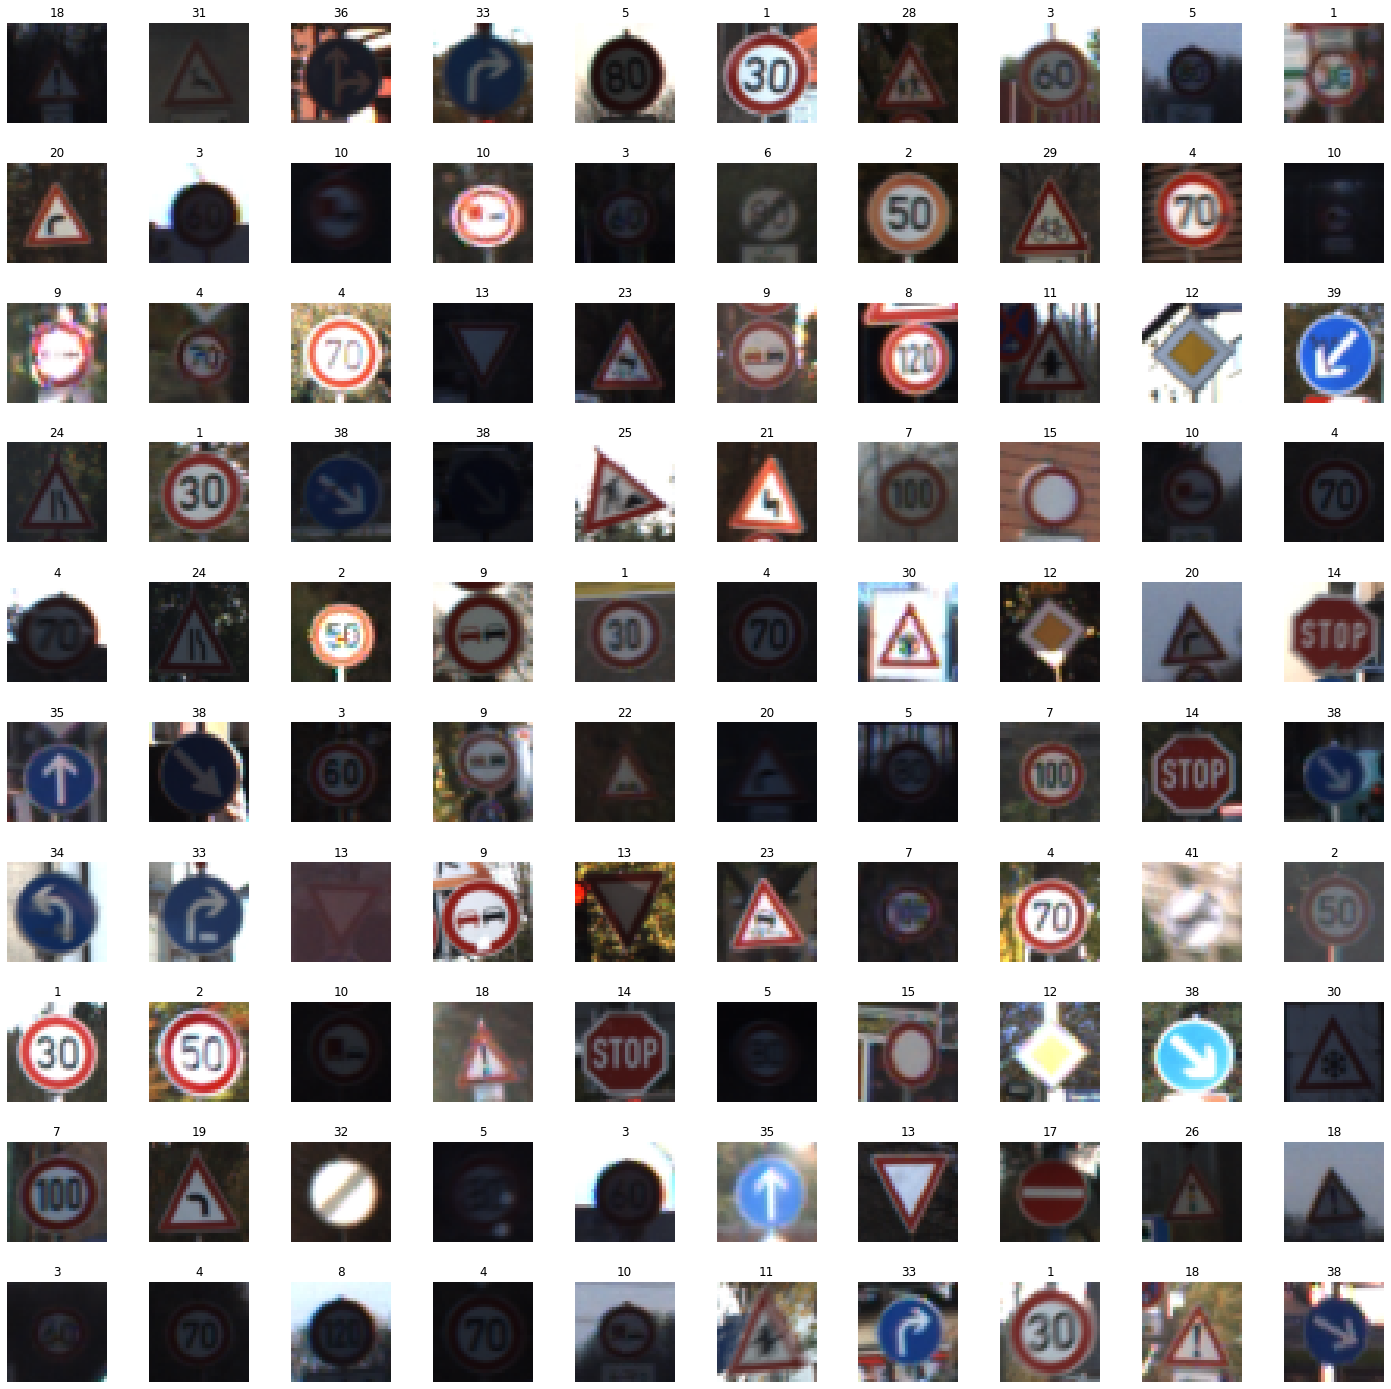

In [7]:
plotRandomImages(X_train, y_train)

## Data Preprocessing

The following process consist in three simple steps to preprocess the dataset.
* Shuffle tha data - as the images are ordered, we shuffle  them to avoid the model use that as a pattern. Also, is good to improve the generalization.
* Convert color images to gray scale - beacuse the color doesn't really matter in this case, what we really care about is the format of the image, no matter if it's blue, red or whatever.
* Normalize the data - as any pixel is represented in 0-255 scale, we can simplify that to 0-1.

In [8]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [9]:
def convert_gray_normalize(X):
    processed = np.sum(X / 3, axis = 3, keepdims = True)
    processed = processed / 255
    return processed

In [10]:
X_train_processed = convert_gray_normalize(X_train)
X_test_processed = convert_gray_normalize(X_test)
X_valid_processed = convert_gray_normalize(X_valid)

In [11]:
print(X_valid_processed.shape, X_valid_processed.min(), X_valid_processed.max())

(4410, 32, 32, 1) 0.0196078431372549 1.0


##### Sample image before and after the preprocessing

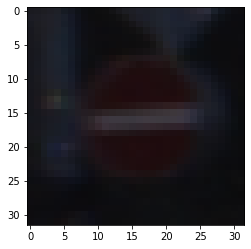

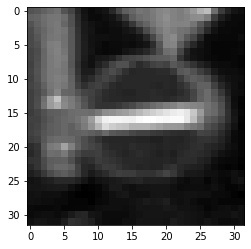

In [12]:
i = 999
plt.imshow(X_train[i])
plt.figure()
plt.imshow(X_train_processed[i].squeeze(), cmap = 'gray')

## Model Training

For this project it will be used the LeNet-5 architecture.

The LeNet-5 is a simple but powerful architecture, wich can be easily trained in a CPU. 

The actual format of the network is composed by two Conv2D layers, the first one with 6 filters, and the second one 16, each one followed by subsamplings.

Then, on the fully connected layers, we use three more Dense layers, with the last one being the output layer *(neurons = n-classes)*.

The representation of the architecture is shown below:

![](LeNet.png)

In [13]:
classes = len(np.unique(y_train))
input_shape = X_train_processed.shape[1:]

print("Total classes: {}, input shape: {}".format(classes, input_shape)) 

Total classes: 43, input shape: (32, 32, 1)


In [14]:
model = Sequential()

model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model.add(AveragePooling2D())
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
model.add(AveragePooling2D())
model.add(Flatten())

# Fully connected layers
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation='relu'))
model.add(Dense(units = classes, activation='softmax'))

In [15]:
# As we have multiple classes (total of 43), the loss function can be sparse categorical crossentropy
# If the number of classes was 2, the better pick probably would be binary crossentropy

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(lr = 0.001),
             metrics = ['accuracy'])

In [16]:
batch = 500
epochs = 100

hist = model.fit(X_train_processed, y_train, batch_size = batch, epochs = epochs, 
          validation_data = (X_valid_processed, y_valid))

Train on 34799 samples, validate on 4410 samples
Epoch 1/100
34799/34799 [==============================] - 98s 3ms/step - loss: 3.3685 - accuracy: 0.1372 - val_loss: 2.8370 - val_accuracy: 0.3023
Epoch 2/100
34799/34799 [==============================] - 46s 1ms/step - loss: 1.8100 - accuracy: 0.5191 - val_loss: 1.4326 - val_accuracy: 0.6132
Epoch 3/100
34799/34799 [==============================] - 45s 1ms/step - loss: 1.0081 - accuracy: 0.7246 - val_loss: 1.0374 - val_accuracy: 0.7036
Epoch 4/100
34799/34799 [==============================] - 41s 1ms/step - loss: 0.7349 - accuracy: 0.8035 - val_loss: 0.8621 - val_accuracy: 0.7481
Epoch 5/100
34799/34799 [==============================] - 41s 1ms/step - loss: 0.5888 - accuracy: 0.8468 - val_loss: 0.7539 - val_accuracy: 0.7896
Epoch 6/100
34799/34799 [==============================] - 42s 1ms/step - loss: 0.4938 - accuracy: 0.8728 - val_loss: 0.7045 - val_accuracy: 0.8066
Epoch 7/100
34799/34799 [==============================] - 41s 

Epoch 56/100
34799/34799 [==============================] - 39s 1ms/step - loss: 0.0127 - accuracy: 0.9972 - val_loss: 0.6504 - val_accuracy: 0.8900
Epoch 57/100
34799/34799 [==============================] - 39s 1ms/step - loss: 0.0179 - accuracy: 0.9951 - val_loss: 0.6263 - val_accuracy: 0.8986
Epoch 58/100
34799/34799 [==============================] - 44s 1ms/step - loss: 0.0157 - accuracy: 0.9960 - val_loss: 0.6148 - val_accuracy: 0.8991
Epoch 59/100
34799/34799 [==============================] - 40s 1ms/step - loss: 0.0085 - accuracy: 0.9983 - val_loss: 0.6213 - val_accuracy: 0.8995
Epoch 60/100
34799/34799 [==============================] - 40s 1ms/step - loss: 0.0064 - accuracy: 0.9991 - val_loss: 0.7172 - val_accuracy: 0.8939
Epoch 61/100
34799/34799 [==============================] - 40s 1ms/step - loss: 0.0102 - accuracy: 0.9977 - val_loss: 0.6822 - val_accuracy: 0.8959
Epoch 62/100
34799/34799 [==============================] - 40s 1ms/step - loss: 0.0160 - accuracy: 0.9958

## Model Evaluation

In [17]:
print(hist.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


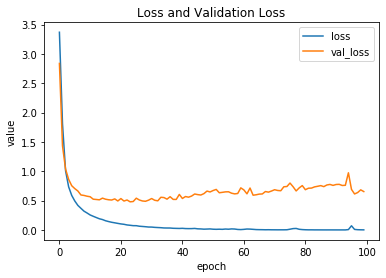

In [18]:
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.title('Loss and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('value')
plt.legend()
plt.show()

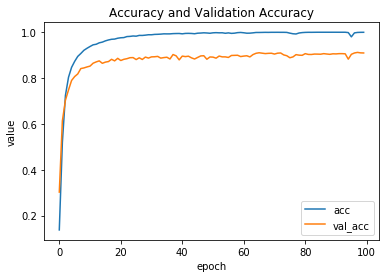

In [19]:
plt.plot(hist.history['accuracy'], label = 'acc')
plt.plot(hist.history['val_accuracy'], label = 'val_acc')
plt.title('Accuracy and Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('value')
plt.legend()
plt.show()

In [20]:
evaluation = model.evaluate(X_test_processed, y_test)

12630/12630 [==============================] - 55s 4ms/step


In [21]:
print("Evalutation loss: {} \nEvaluation accuracy: {}".format(evaluation[0], evaluation[1]))

Evalutation loss: 1.205762659731636 
Evaluation accuracy: 0.8973079919815063


In [22]:
predicted = model.predict_classes(X_test_processed)

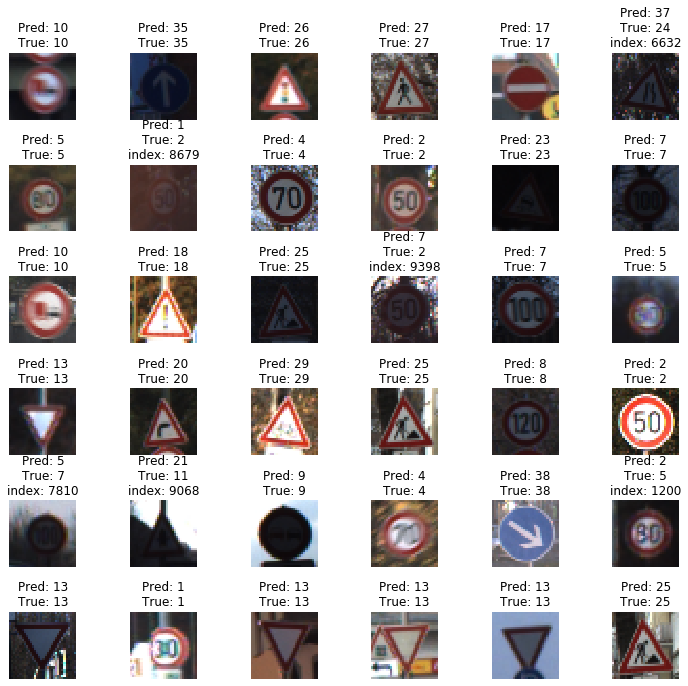

In [23]:
''' 
    This code is used to create a grid of LxW dimensions and plot random images from the test data
    within the grid. The title of the image contain the Predicted class and the True value.
    For images where the model missed the prediction, the index of the image is also displayed, so we
    can make a further analysis and know why the the model predicted wrong.
'''

L, W = 6, 6
fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in range(L*W):
    index = np.random.randint(0, len(predicted))
    axes[i].imshow(X_test[index])
    if predicted[index] == y_test[index]:
        axes[i].set_title("Pred: {}\nTrue: {}".format(predicted[index], y_test[index]))
    else:
            axes[i].set_title("Pred: {}\nTrue: {}\nindex: {}".format(predicted[index],
                                                             y_test[index], index))
    axes[i].axis('off')
plt.subplots_adjust(wspace = 0.8)

### Testing with sample image with high quality

This is a simple demonstration of how we can use the model. In order to do that I've downloaded a 30 km/h sign from the internet, and make the whole process until I get the prediction

(225, 225, 3)


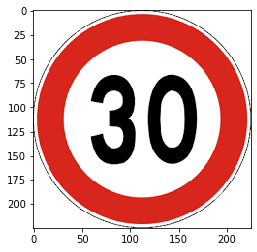

In [147]:
img = cv2.imread('30kh.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
print(img.shape)

As we can see, the shape of the image is not what our model expect (32x32x1), so we make a simple processesing the achive the correct input shape.

Note that I've addicionated one more dimension, because that the predicion function expect a 4-d array, even if we have only one image. So, for this example, the final shape will be (1, 32, 32, 1), with the image normalized and grayscaled

In [149]:
def process_img(img):
    img_resized = cv2.resize(img, (32,32))
    img_expand = np.expand_dims(img_resized, axis=0)
    img_processed = convert_gray_normalize(img_expand)
    return img_processed

In [150]:
img = process_img(img)
img.shape

(1, 32, 32, 1)

##### Image after the processing

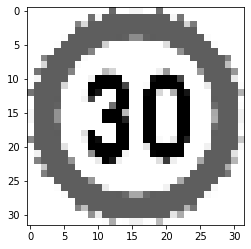

In [110]:
plt.imshow(img.squeeze(), cmap='gray')

So finally we can predict and use the get_key function to see our final result in a string format (that's why I've used the dictionary)

In [151]:
pred = model.predict_classes(img)

In [154]:
# function to return key for any value 
def get_key(val, my_dict): 
	for key, value in my_dict.items(): 
		if val == value: 
			return key         
	return "Invalid"

In [153]:
print(get_key(pred, dict_ans))

Speed limit (30km/h)
